In [19]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer
from qiskit.circuit.library.standard_gates import PhaseGate
from qiskit.execute_function import execute
from qiskit.tools.visualization import plot_histogram
from numpy import pi as PI
%matplotlib inline

In [20]:
def append_qft(circuit, qubit_num):
    def append_step(for_qubit):
        circuit.h(for_qubit)
        for control_qubit in range(for_qubit):
            circuit.cp(PI / (2 ** (for_qubit - control_qubit)),
                       control_qubit, for_qubit)

    for cur_step in reversed(range(qubit_num)):
        append_step(cur_step)

    for cur_swap in range(qubit_num // 2):
        circuit.swap(cur_swap, qubit_num - 1 - cur_swap)


def qft(qubit_num, inverted=False, draw_filename=None):
    register = QuantumRegister(qubit_num, "data")
    circuit = QuantumCircuit()
    circuit.add_register(register)

    append_qft(circuit, qubit_num)
    if inverted:
        circuit = circuit.inverse()

    result_gate = circuit.to_gate(label="IQFT" if inverted else "QFT")

    return result_gate, circuit.draw("mpl", filename=draw_filename)

$$
\begin{matrix}
U =
\begin{bmatrix}
1 & 0 \\
0 & e^{2\pi i \theta }
\end{bmatrix}\\
P_{gate} = \begin{bmatrix}
1 & 0 \\
0 & e^{i \lambda }
\end{bmatrix}
\end{matrix}
\Longrightarrow
\lambda = 2\pi\theta
$$

In [21]:
theta = 1 / 3
lambda_ = 2 * PI * theta

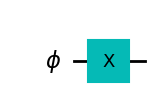

In [22]:
# Input data
counting_qubits_num = 3
U = PhaseGate(lambda_)
phi = QuantumCircuit(QuantumRegister(1, name='\\phi'))
phi.x(0)
phi.draw('mpl')

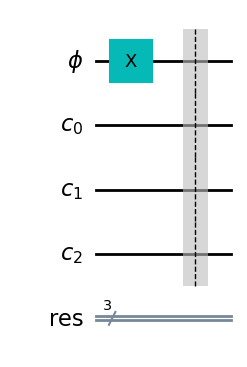

In [23]:
# Setting up the circuit
qpe_circuit = QuantumCircuit(
    *phi.qregs,
    QuantumRegister(counting_qubits_num, name='c'),
    ClassicalRegister(counting_qubits_num, "res")
)
qpe_circuit = qpe_circuit.compose(phi)
CU = U.control(1)

qpe_circuit.barrier()
qpe_circuit.draw("mpl")

In [16]:
counting_qubits = range(phi.num_qubits,
                        phi.num_qubits + counting_qubits_num)
qpe_circuit.h(counting_qubits)

for cur_qubit in range(counting_qubits_num):
    for _ in range(2 ** cur_qubit):
        qpe_circuit.append(CU, [cur_qubit + phi.num_qubits,
                                *range(phi.num_qubits)])

qpe_circuit.barrier()
qpe_circuit.append(qft(counting_qubits_num, True)[0], counting_qubits)

qpe_circuit.barrier()
qpe_circuit.measure(counting_qubits, range(counting_qubits_num))

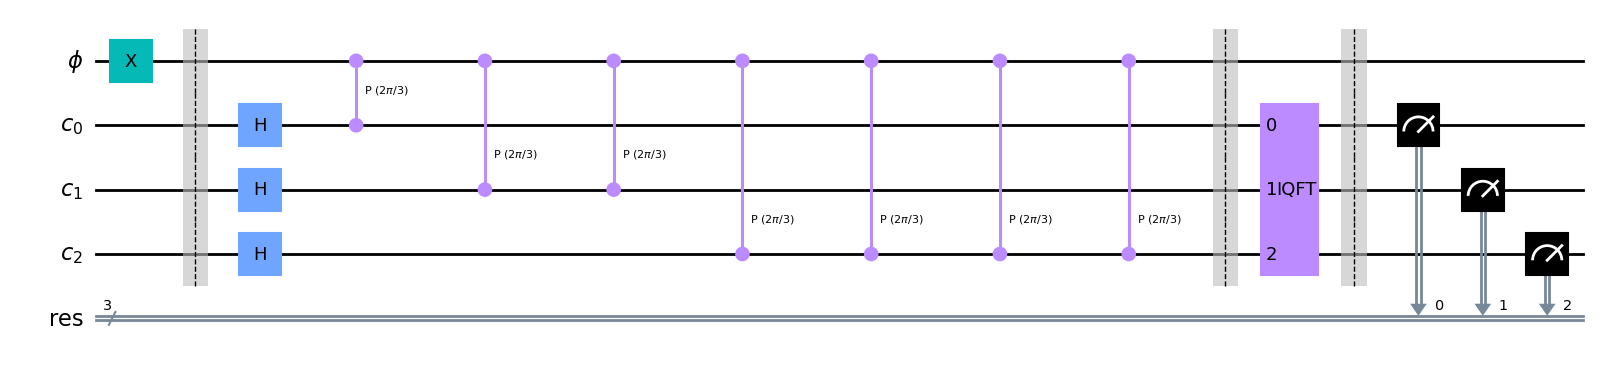

In [17]:
qpe_circuit.draw("mpl")

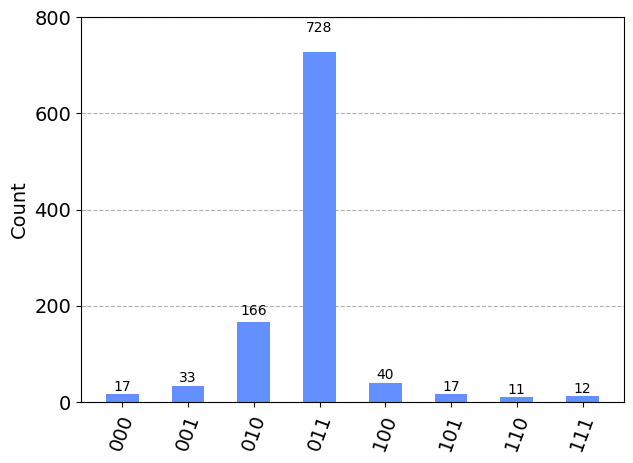

In [18]:
sim = Aer.get_backend("aer_simulator")
job = execute(qpe_circuit, sim)
plot_histogram(job.result().get_counts())